# Performance Fields and Cortical Magnification in V1 and V2

Noah C. Benson$^{1,2,*}$, Eline Kupers$^{1,2}$, Marisa Carasco$^{1,2}$, Jonathan Winawer$^{1,2}$

$^1$Department of Psychology and $^2$Center for Neural Sciences, New York University, New York, NY 10031  
$^*$ To whom correspondences should be addressed; email: [nben@uw.edu](mailto:nben@uw.edu)

## Configuration

Here, we configure various paths and settings that are used throughout the rest of the notebook.

In [32]:
# The directory to put the figures and output images in. If this is None,
# then no figures will be exported.
figures_path = '/data/performance-fields/figures'

# The colors we will use in the plots for different boundaries.
colors = {'vertical':   (0.7, 0.2, 0.7),
          'horizontal': (0.6, 0.6, 0.6),
          'dorsal':     (0.8, 0.2, 0.1),
          'ventral':    (0.1, 0.5, 0.8),
          'M':          (0.1, 0.8, 0.25),
          'F':          (0.5, 0.2, 0.75)}

## Initialization

In this section, we import and configure libraries and prepare various data for use in the rest of the notebook.

### Libraries

In [2]:
# Some standard libraries:
import os, sys, six, h5py, pandas
import numpy           as np
import scipy           as sp
import scipy.stats     as stats
import pyrsistent      as pyr
from   functools   import reduce
from   importlib   import reload

# Import nearopythy and pimms (related data-structures library)
import pimms
import neuropythy as ny

sys.path.insert(0, '/home/nben/code/performance-fields')
import visual_performance_fields

#### Graphics Libraries and Configuration

These two cells import and configure matplotlib and pyplot for graphics/plotting. Usually these two cells would go in a single cell, but due to a bug in (some versions of) matplotlib, all matplotlib.rc configurations must go in a separate cell after the '%matplotlib inline'-type magic codes.

In [3]:
# Graphics libraries:
import ipyvolume         as ipv
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.tri    as tri
import seaborn           as sns
# Matplotlib and Graphics Configuration (more in next 2 cells due
# to matplotlib bug that prevents them from working when together)

In [4]:
%gui qt
%matplotlib inline

In [5]:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue','Helvetica Neue','Helvetica','Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

#### Warnings

In general, we want warnings to be treated as errors, but there are a few warnings known to arise from modules that we have no control over (e.g., a FutureWarnings from scipy about deprecated array indexing). These we explicitly ignore.

In [6]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning,
                        module='scipy.stats',
                        message='Using a non-tuple sequence for multidimensional.*')

### Utility Functions

These cells contain utility and graphical functions for use with the data loaded above.

---

**`line_quantiles_plot`**

This function plots boxes and lines for quantile plots and is used later in this notebook to construct figures.

In [7]:
# Utility functions for graphics
def line_quantiles_plot(xs, ys, quantiles=0.25, color='k', line=True, axes=None, alpha=None):
    '''
    line_quantiles_plot(xs, ys) plots the line specified by the vector xs and the median
      of each row of the ys matrix. The 0.25 and 0.75 quantiles are also plotted as
      semi-transparent regions around the median line.
    
    The following options may be provided (listed in argument order):
      * quantiles (default: 0.25) specifies the quantiles to plot; quantiles are
        plotted with higher alpha when they are closer to 0.5; if this is a list or
        tuple, then the quantiles plotted are unique(min([quantiles, 1-quantiles]));
        quantile regions are always plotted symmetrically around the median, so either
        0.25 or 0.75 will result in a quantile region from quantile 0.25 to 0.75.
      * color (default: 'k') specifies the color of the plot.
      * line (default: True) specifies whether to plot the median line.
      * axes (default: None) specifies the axes on which to plot.
      * alpha (default: None) specifies the alpha to use in the shaded regions; if None
        then uses 1/n where n is the number of quantiles requested.
    '''
    import matplotlib.pyplot as plt
    # parse axes
    axes = plt.gca() if axes is None else axes
    # parse quantiles
    quantiles = np.asarray(quantiles)
    if line:
        if len(quantiles.shape) == 0: quantiles = np.asarray([quantiles, 0.5])
        else: quantiles = np.concatenate([quantiles, [0.5]])
    quantiles = np.unique(np.round(np.min([quantiles, 1-quantiles], axis=1), 6))
    # parse alpha
    if alpha is None: 
        q = np.setdiff1d(quantiles, [0.5])
        alpha = 1.0 / (1 + len(q))
    # turn plot color into an rgba
    color = matplotlib.colors.to_rgba(color)
    if len(color) == 3: color = np.concatenate([color, [1.0]])
    # see if ys needs to be transposed
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    if len(ys.shape) != 2: raise ValueError('ys must be a matrix')
    elif ys.shape[0] != len(xs):
        if ys.shape[1] == len(xs): ys = ys.T
        else: raise ValueError('shape of ys does not match length of xs')
    # get the quantile values
    percentiles = 100.0 * quantiles
    qvals_lo = np.transpose([np.percentile(yrow, percentiles) for yrow in ys])
    qvals_hi = np.transpose([np.percentile(yrow, 100 - percentiles) for yrow in ys])
    # make polygons
    polys = [(np.concatenate([(xs, vlo), np.fliplr([xs, vhi])], axis=1)
              if q != 0.5 else
              np.asarray([xs, vlo]))
             for (q,vlo,vhi) in zip(quantiles, qvals_lo, qvals_hi)]
    ims = []
    for (q,(x,y)) in zip(quantiles, polys):
        rgba = np.array(color)
        if q == 0.5:
            ims.append(axes.plot(x, y, c=rgba))
        else:
            rgba *= (1, 1, 1, alpha)
            im = axes.fill(x,y)
            matplotlib.pyplot.setp(im, facecolor=rgba)
            ims.append(im)
    return tuple(ims)

---

**`DROI_cortex_plot()`**

This function can make either 2D or 3D plots of the subject distance-based regions of interest (DROIs). The surface argument may be the name of a surface or 'flatmap' for a 2D plot.

In [ ]:
# We use the standard colors for these ROI plots.
roi_surface_colors = colors
# The function itself.
def DROI_cortex_plot(sid, h, para, rois=None, surface='very_inflated', figure=None, axes=None,
                     lines={'horizontal':'white','vertical':'black'}):
    '''
    DROI_cortex_plot(sid, h, boundary) plots the given subject and hemisphere with DROIs
      for the given boundary colored. The boundary should be 'vertical', 'horizontal',
      'ventral', or 'dorsal'.
    '''
    hem = data.subjects[sid].hemis[h]
    if surface == 'flatmap': msh = ny.to_flatmap('occipital_pole', hem)
    else: msh = hem.surface(surface)
    va = msh.prop('inf_visual_area')
    ec = msh.prop('inf_eccentricity')
    pa = msh.prop('inf_polar_angle')
    if pimms.is_str(para) and para in roi_surface_colors: para = [para]
    if pimms.is_vector(para, str):
        if rois is None: rois = data.DROI_details[sid][h]
        clrs = np.zeros([msh.vertex_count, 3])
        for p in para:
            c = np.asarray(roi_surface_colors[p])
            rd = rois[p]
            angbins = list(reversed(sorted(rd.keys())))
            nbins = len(angbins)
            for (ii,ang) in enumerate(angbins):
                cc = c * (1 - ii/nbins) + np.ones(3)*(ii/nbins)
                jj = rd[ang]['indices']
                if len(jj) > 0:
                    clrs[msh.tess.index(jj),:] = cc
        alpha = np.sum(clrs, axis=1) > 0
        clrs = np.hstack([clrs, np.reshape(alpha, (-1,1))])
        mask = None
    else:
        mask = ('prf_variance_explained', 0.04, 1)
        clrs = ny.graphics.core.cortex_plot_colors(msh, color=para, mask=mask)
    # Okay, make the figure:
    if ny.is_flatmap(msh):
        if axes is not None: f = axes
        elif figure is None: f = plt.gca()
        else: f = figure
        ny.cortex_plot(msh, axes=f, color=clrs, mask=mask)
    else:
        f = ipv.figure(width=800, height=450) if figure is None else figure
        ny.cortex_plot(msh, figure=f, color=clrs, mask=mask)
    # Draw the lines:
    if pimms.is_str(lines): lines = ['lines']
    if pimms.is_vector(lines): lines = {ln:'black' for ln in lines}
    if lines is None: lines = {}
    lines = {k:v for (k,v) in six.iteritems(lines) if k in roi_surface_colors}
    if 'vertical' in lines:
        c = lines['vertical']
        if 'dorsal' not in lines: lines['dorsal'] = c
        if 'ventral' not in lines: lines['ventral'] = c
        del lines['vertical']
    (u,v) = msh.tess.indexed_edges
    vnorms = np.zeros((2,msh.vertex_count)) if ny.is_flatmap(msh) else msh.vertex_normals
    for (k,clr) in six.iteritems(lines):
        ww = np.zeros(msh.vertex_count)
        if k == 'horizontal':
            ww[(pa >  90) & (va == 1)] = 1
            ww[(pa <= 90) & (va == 1)] = -1
        elif k == 'ventral':
            ww[(pa < 90) & (va == 1)] = 1
            ww[(pa < 90) & (va == 2)] = -1
        elif k == 'dorsal':
            ww[(pa > 90) & (va == 1)] = 1
            ww[(pa > 90) & (va == 2)] = -1
        else: raise ValueError('bad line key: %s' % (k,))
        ww[(ec > 8) | (ec < 0.4)] = 0
        ee = np.where(ww[u]*ww[v] == -1)[0]
        x = np.mean([msh.coordinates[:,u[ee]], msh.coordinates[:,v[ee]]], axis=0)
        nrms = np.mean([vnorms[:,u[ee]], vnorms[:,v[ee]]], axis=0)
        x += 0.5*nrms
        if ny.is_flatmap(msh):
            f.scatter(x[0], x[1], c=clr, s=0.5)
        else:
            ipv.scatter(x[0], x[1], x[2], color=clr, size=0.5, marker='sphere', figure=f)
    return f

### Declare the Dataset.

In [49]:
data = ny.data['visual_performance_fields']

## Plots and Analyses

### Distance-based ROI Surface Areas

This section plots the distance-based ROI surface areas for each of the angle-wedges in increasing order. This is the primary figure of the paper regarding cortical surface area. This first cell sets up a few functions that construct various components of the plots such as the individual box-plots.

In [9]:
paradigm_order = ['ventral','dorsal','vertical','horizontal']
boxwidth       = 1
ylabels        = {'surface_area_mm2': r'Surface Area [cm$^2$]',
                  'thickness_mm':     r'Mean Gray Thickness [mm]',
                  'volume_mm3':       r'Gray Volume [cm$^3$]'}
scales         = {'surface_area_mm2': 0.01,
                  'volume_mm3':       0.001,
                  'thickness_mm':     1}
yminmax        = {'surface_area_mm2': (0,15),
                  'volume_mm3':       (0,1.6),
                  'thickness_mm':     (1.25,2.75)}
yticks         = {'surface_area_mm2': np.arange(0,16,3),
                  'volume_mm3':       np.arange(0,1.61,0.2),
                  'thickness_mm':     np.arange(1.25,2.8,0.25)}
def droi_box_plot(x, ys, color, ax, scale=0.01, boxwidth=boxwidth,
                  bootstraps=1000, zorder=1):
    '''
    Given x value, y values, a color, and an axes object, makes a box plot.
    '''
    boxhwidth = boxwidth * 0.5
    ys = ys[np.isfinite(ys)] * scale
    n = len(ys)
    ypctls = np.percentile(ys, [2.5, 25, 50, 75, 97.5])
    ii0 = np.arange(n)
    mdsem = np.std([np.percentile(ys[ii], 50)
                    for _ in range(bootstraps)
                    for ii in [np.random.choice(ii0, n)]])
    mdsem *= 1.96
    y = ypctls
    clr = np.array(colors[color] if pimms.is_str(color) else color)
    ps = ax.plot([x,x], y[[0,-1]], 'k-', lw=0.5)
    for p in ps: p.set_zorder(-zorder)
    rect = plt.Rectangle([x-boxhwidth, y[1]], boxwidth, (y[3]-y[1]),
                         fill=True, edgecolor=clr, linewidth=0.75,
                         facecolor=(1 - 0.5*(1 - clr)), zorder=zorder)
    ax.add_patch(rect)
    ps1 = ax.plot([x-boxhwidth, x+boxhwidth], [y[2], y[2]], '-', lw=0.75, c=clr)
    ps2 = ax.plot([x, x], [y[2]-mdsem, y[2]+mdsem], '-', lw=0.75, c=clr)
    for p in ps1: p.set_zorder(zorder + 1)
    for p in ps2: p.set_zorder(zorder + 1)
    return y
def droi_quant_plot(quant, para, axes=None, dx=0, zorder=1, cumulative=True,
                    boxwidth=boxwidth, color=None, angles=data.roi_angles):
    boxhwidth = boxwidth * 0.5
    if color is None: color = colors[para]
    ax = plt.gca() if axes is None else axes
    angles = np.asarray(angles)
    # if cumulative, fix the data
    ys = np.asarray(data.DROI_summary[para][quant])
    if not cumulative:
        (cum,yr) = (0, [])
        for yy in ys:
            yr.append(yy - cum)
            cum = yy
        ys = yr
    # Start by making the boxes...
    yy = []
    for (x,ys) in zip(angles, ys):
        ys = droi_box_plot(x + dx, ys, para, ax, scale=scales[quant], zorder=zorder)
        yy.append(ys)
    yy = np.transpose(yy) # will be 5 x n where the 5 are (2.5%, 25%, 50%, 75%, 97.5%)
    (y25,y50,y75) = yy[1:-1]
    # we need to make trend lines/shaded regions
    deg = 4
    (t25,t50,t75) = [np.polyfit(angles + dx, y, deg) for y in yy[1:-1]]
    # we want to sample at these x's...
    x = np.linspace(angles[0]+dx, angles[-1]+dx, 200)
    xmtx = np.transpose([x**q for q in reversed(range(deg+1))])
    # first do the shaded region...
    y = np.concatenate([np.dot(xmtx, t75), np.flip(np.dot(xmtx,t25))])
    tclr = np.concatenate([color, [0.35]])
    pgon = plt.Polygon(np.transpose([np.concatenate([x, np.flip(x)]), y]),
                       fill=True, edgecolor=None, linewidth=None, zorder=-zorder-2,
                       facecolor=tclr)
    ax.add_patch(pgon)
    # and make a dotted line...
    ps = ax.plot(x, np.dot(xmtx, t50), ':', c=color, lw=1)
    for p in ps: p.set_zorder(-zorder-1)
    # That's all!
    return ax
def droi_diff_plot(quant, para1, para2, axes=None, dx=0, zorder=1,
                   color=None, angles=data.roi_angles, cumulative=False,
                   bootstraps=1000):
    if color is None: color = np.array([0,0.5,0,1])
    ax = plt.gca() if axes is None else axes
    angles = np.asarray(angles)
    # depending on if we're doing a cumulative or instantaneous plot,
    # we gather different sets of y-values
    ys1 = np.asarray(data.DROI_summary[para1][quant])
    ys2 = np.asarray(data.DROI_summary[para2][quant])
    if not cumulative:
        res = []
        for ys in (ys1,ys2):
            (cum,yr) = (0, [])
            for yy in ys:
                yr.append(yy - cum)
                cum = yy
            res.append(yr)
        (ys1,ys2) = [np.asarray(u) for u in res]
    # okay, now do the plotting...
    yln = []
    for (x,y1,y2) in zip(angles+dx, ys1, ys2):
        ys = []
        n = len(y1)
        for bs in range(bootstraps):
            bsii = np.random.choice(np.arange(n), n)
            yy1 = y1[bsii]
            yy2 = y2[bsii]
            mu = np.nanmean([yy1, yy2], axis=0)
            dy = yy1 - yy2
            #kk = mu > 0
            #(mu,dy) = (mu[kk], dy[kk])
            ys.append(np.nanmedian(dy / mu * 100))
        (yl,y,yu) = np.percentile(ys, [2.5,50,97.5])
        #(yl,y,yu) = np.percentile(ys, [16,50,84])
        ax.plot([x, x], [yl, yu], '-', c=color, lw=0.5)
        ax.plot(x, y, '.', c=color, ms=1)
        yln.append(y)
    ax.plot(angles+dx, yln, '-', color=color, lw=0.5)
    return ax

In this cell, we use the above functions to produce the plot itself.

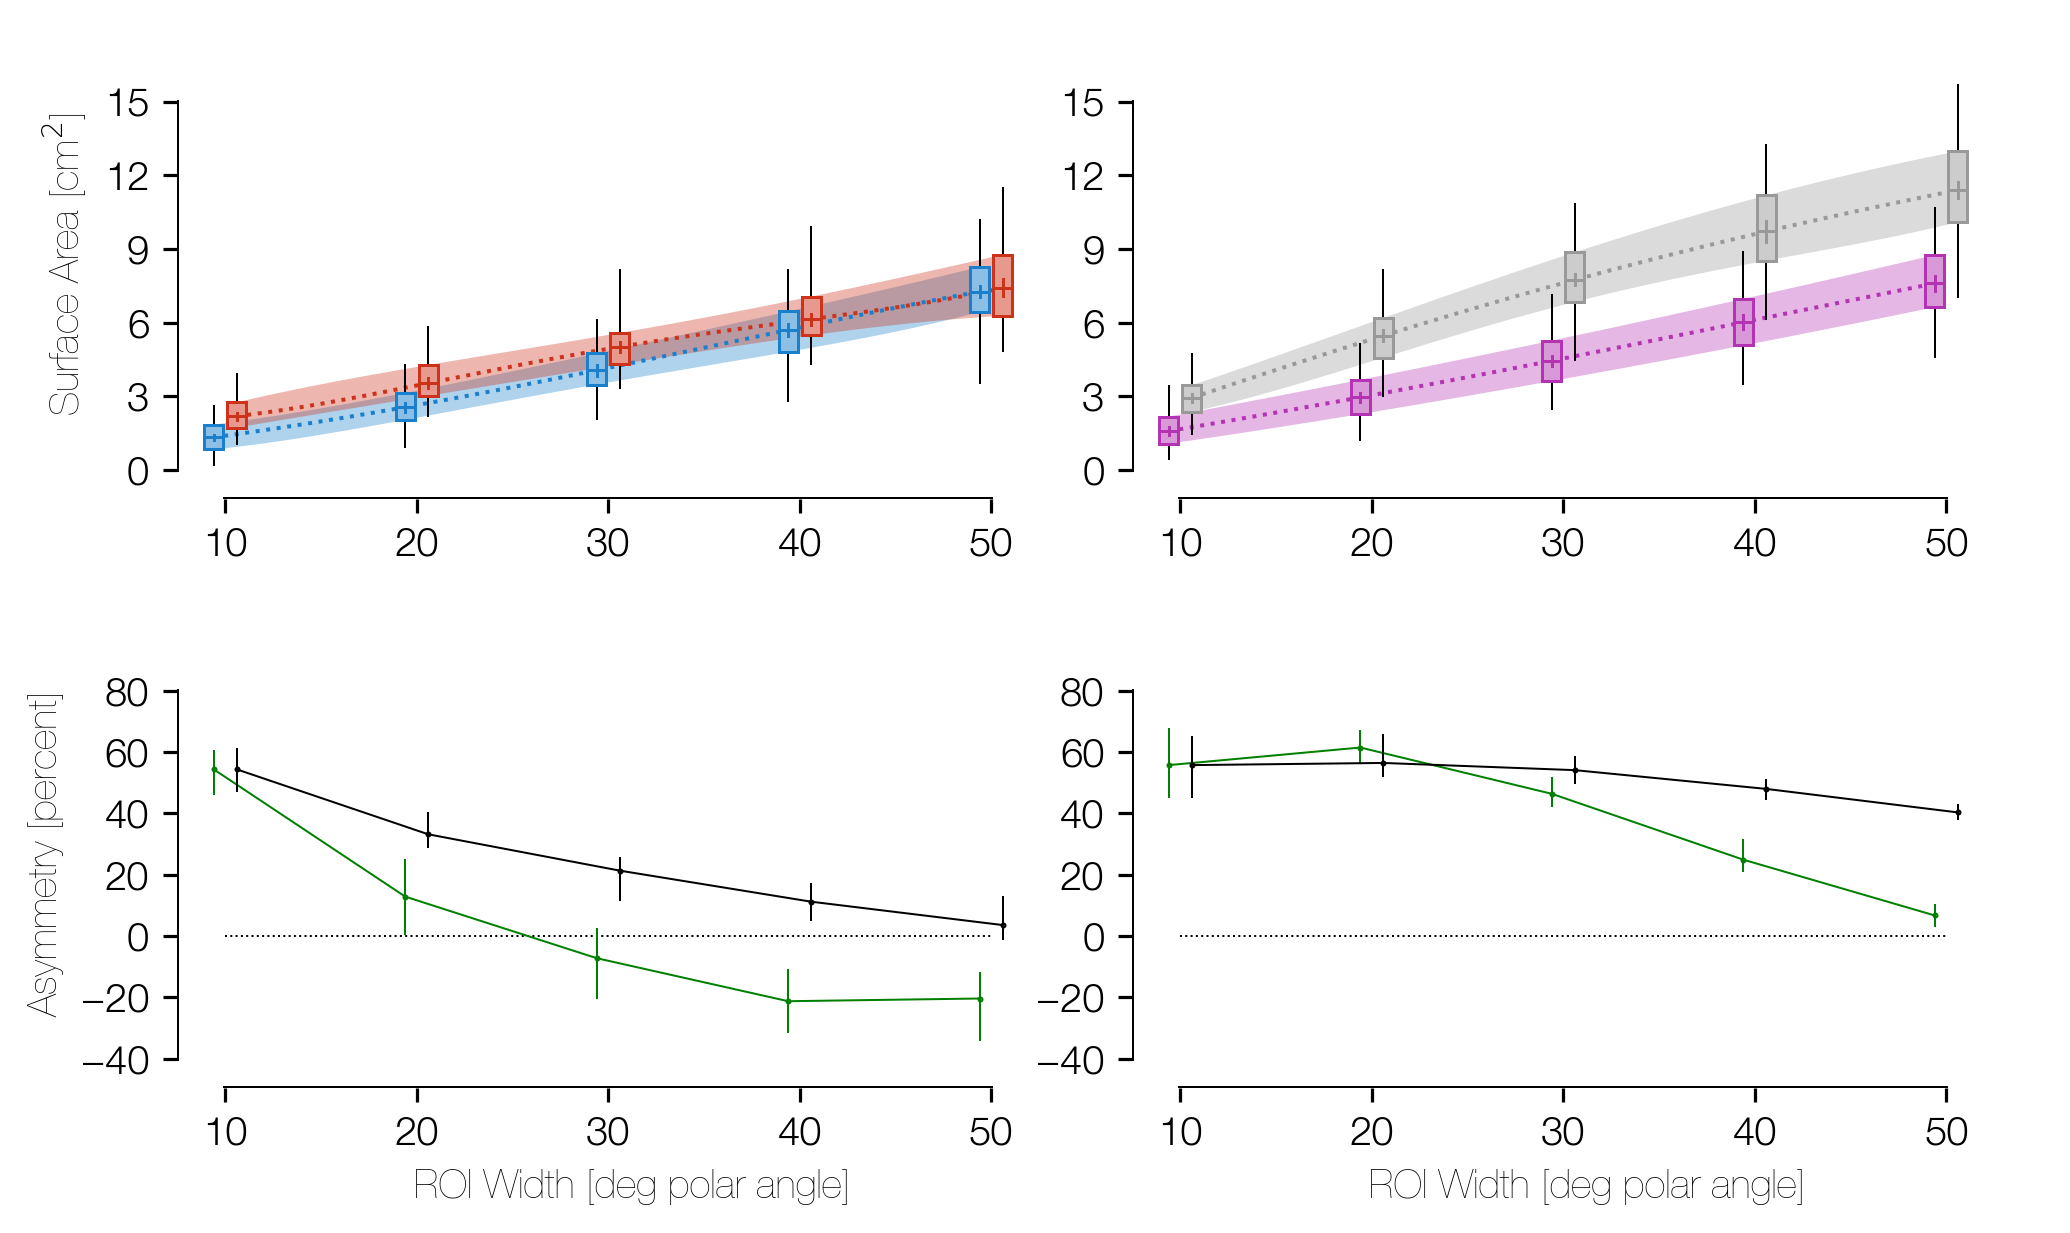

In [11]:
# Setup the figure.
(fig,axs) = plt.subplots(2,2, figsize=(7, 4.33), dpi=72*4)
fig.subplots_adjust(0.075,0.125,1,0.975,0.05,0.25)

# Plot the various cumulative plots first.
dx = 0.6
tcum = True
droi_quant_plot('surface_area_mm2', 'ventral', axes=axs[0,0], dx=-dx, cumulative=tcum)
droi_quant_plot('surface_area_mm2', 'dorsal', axes=axs[0,0], dx=dx, cumulative=tcum)
droi_quant_plot('surface_area_mm2', 'vertical', axes=axs[0,1], dx=-dx, cumulative=tcum)
droi_quant_plot('surface_area_mm2', 'horizontal', axes=axs[0,1], dx=dx, cumulative=tcum)

# Now the rest.
droi_diff_plot('surface_area_mm2', 'dorsal', 'ventral', axes=axs[1,0], dx=-dx)
droi_diff_plot('surface_area_mm2', 'horizontal', 'vertical', axes=axs[1,1], dx=-dx)
droi_diff_plot('surface_area_mm2', 'dorsal', 'ventral', axes=axs[1,0],
               cumulative=True, color=[0,0,0,1], dx=dx)
droi_diff_plot('surface_area_mm2', 'horizontal', 'vertical', axes=axs[1,1],
               cumulative=True, color=[0,0,0,1], dx=dx)

# Fix the limits and axes.
(xmin0, xmax0) = (7.5, 55)
(xmin, xmax) = (10, 50)
for ax in axs.flatten():
    ax.set_xticks(data.roi_angles)
    ax.set_xlim((xmin0, xmax0))
    for sp in six.itervalues(ax.spines): sp.set_visible(False)
(ymin0, ymax0) = (-1.2, 18)
(ymin, ymax) = (0, 15)
for ax in axs[0]:
    ax.set_xticks(data.roi_angles)
    ax.set_ylim((ymin0, ymax0))
    ax.plot([xmin0,xmin0], [ymin,ymax], 'k-', lw=1)
    ax.plot([xmin,xmax], [ymin0,ymin0], 'k-', lw=1)
    ax.set_yticks(yticks['surface_area_mm2'])
axs[0,0].set_ylabel(ylabels['surface_area_mm2'])
dy = [(ymax0 - ymax) / (ymax - ymin),
      (ymin0 - ymin) / (ymax - ymin)]
(ymin, ymax) = (-40, 80)
(ymin0, ymax0) = (ymin + dy[1]*(ymax-ymin), ymax + dy[0]*(ymax-ymin))
for ax in axs[1]:
    ax.set_xticks(data.roi_angles)
    ax.set_ylim((ymin0, ymax0))
    ax.set_xlabel('ROI Width [deg polar angle]')
    ax.plot([xmin0,xmin0], [ymin,ymax], 'k-', lw=1)
    ax.plot([xmin,xmax], [ymin0,ymin0], 'k-', lw=1)
    ax.set_yticks([-40, -20, 0, 20, 40, 60, 80])
    ps = ax.plot([xmin, xmax], [0,0], 'k:', lw=0.5)
    for p in ps: p.set_zorder(-2)
axs[1,0].set_ylabel("Asymmetry [percent]")

if figures_path is not None:
    flnm = os.path.join(figures_path, 'surface_areas.pdf')
    plt.savefig(flnm, dpi=72*8)

### ROIs on the Cortical Surface

These cells demonstrate how to (1) plot the ROIs on the flattened cortical surface and (2) export the ROI data to Mathematica (which is what we used to produce high quality 3D images).

---

**Plotting summary DROI figures for a hemisphere.**

This first cell defines the function `DROI_summary_figure`, which uses the `DROI_cortex_plot` function defined above (`Initialization >> Utility Functions`) to produce summary plots of a given subject's hemisphere. These plots provide a good intuition about the quality of the automated boundary-finding and ROI generation methods.

In [22]:
def DROI_summary_figure(sid, h):
    '''
    DROI_summary_figure(sid, h) yields a pyplot figure object on which has been plotted four panels,
      two for the subject and hemisphere's polar angle and eccentricity and two showing the DROIs
      for the subject.
    '''
    (fig,axs) = plt.subplots(2,2, figsize=(7,7), dpi=288)
    fig.subplots_adjust(0,0,1,1,0,0)
    for ax in axs.flatten(): ax.axis('off')
    DROI_cortex_plot(sid, h, 'prf_polar_angle', surface='flatmap', figure=axs[0,0])
    DROI_cortex_plot(sid, h, 'prf_eccentricity', surface='flatmap', figure=axs[0,1])
    DROI_cortex_plot(sid, h, ['vertical','horizontal'], surface='flatmap', figure=axs[1,0])
    DROI_cortex_plot(sid, h, ['dorsal','ventral'], surface='flatmap', figure=axs[1,1])
    return fig

This cell, when run, will export images of the subjects to the `figures_path` directory. If that directory is `None` then this will do nothing.

In [ ]:
if figures_path is not None:
    rois_path = os.path.join(figures_path, 'summaries')
    if not os.path.isdir(rois_path):
        os.makedirs(rois_path, mode=0o664)
    for sid in subject_list:
        print(sid)
        for h in ('lh','rh'):
            flnm = os.path.join(rois_path, '%d_%s.png' % (sid,h))
            if os.path.isfile(flnm): continue
            fig = DROI_summary_figure(sid, h)
            plt.savefig(flnm, bbox_inches='tight', dpi=288)
            plt.close(fig)

---

**Export DROI data to Mathematica for plotting.**

For the 3D plots in the paper, we used Mathematica's 3D rendering engine to produce high quality 3D images. As of when this paper/notebook were written, Mathematica produces smoother surfaces and fewer artifacts and allows for more control over lighting.To print the DROI data in a string format that can simply be copied-and-pasted over to Mathematica, you can use this cell.

Note that this produces a fairly large block of text, but for any single hemisphere it should be small enough to paste across programs without issue.

In [26]:
sid = 177746
h = 'lh'

# These are the rois we will print out.
rois = data.DROI_details[sid][h]

# Generate the text as a list of strings, which we will join.
ss = ["<|"]
for (k,v) in six.iteritems(rois):
    ss.append('"%s" -> <|' % k)
    for (ang,q) in six.iteritems(v):
        q = q['indices']
        ss.append('%d -> {' % ang)
        for (ii,u) in enumerate(q):
            if ii > 0: ss.append(", ")
            ss.append(str(u))
        ss.append('}')
        if ang < 50: ss.append(',')
    ss.append('|>')
    ss.append(',\n')
ss[-1] = "|>"

print(''.join(ss))

### V1 Sizes in Terms of Gender

Something that we want to be able to examine is the breakdown of V1 sizes in terms of properties like gender and age. This section performs these calculations and plots.

---

These initial functions simply perform the basic calculations about a subject--e.g., what is the surface area of their V1?

In [27]:
def subject_V1_surface_area(sid, h, area_property='midgray_surface_area'):
    hem = data.subjects[sid].hemis[h]
    ii = hem.indices
    for mask in [('inf_visual_area', 1), ('inf_eccentricity', 1, 6)]:
        ii = np.intersect1d(ii, hem.mask(mask))
    return np.nansum(hem.property(area_property, mask=ii))
def subject_V1_thickness(sid, h):
    hem = data.subjects[sid].hemis[h]
    ii = hem.indices
    for mask in [('inf_visual_area', 1), ('inf_eccentricity', 1, 6)]:
        ii = np.intersect1d(ii, hem.mask(mask))
    return np.nanmean(hem.property('thickness', mask=ii))
def subject_V1_volume(sid, h, area_property='midgray_surface_area'):
    hem = data.subjects[sid].hemis[h]
    ii = hem.indices
    for mask in [('inf_visual_area', 1), ('inf_eccentricity', 1, 6)]:
        ii = np.intersect1d(ii, hem.mask(mask))
    area = hem.property(area_property, mask=ii)
    thic = hem.property('thickness', mask=ii)
    return np.nansum(area * thic)
def subject_cortex_surface_area(sid, h, area_property='midgray_surface_area'):
    hem = data.subjects[sid].hemis[h]
    ii = hem.mask('cortex_label')
    return np.nansum(hem.property(area_property, mask=ii))
def subject_cortex_volume(sid, h, area_property='midgray_surface_area'):
    hem = data.subjects[sid].hemis[h]
    ii = hem.mask('cortex_label')
    area = hem.property(area_property, mask=ii)
    thic = hem.property('thickness', mask=ii)
    return np.nansum(area * thic)

---

To make this plot, we want to use seaborn; we will build up a dataframe that makes the plotting easy.

In [34]:
dat = ny.auto_dict(None, [])
for sid in data.subject_list:
    dat['sid'].append(sid)
    dat['Gender'].append(data.gender[sid])
    dat['Age'].append(data.agegroup[sid])
    v1sa = subject_V1_surface_area(sid,h) / 100.0
    v1vo = subject_V1_volume(sid,h) / 1000.0
    cxsa = subject_cortex_surface_area(sid,h) / 100.0
    cxvo = subject_cortex_volume(sid,h) / 1000.0
    dat[r'V1 Surface Area [cm$^2$]'].append(v1sa)
    dat[r'V1 Gray Volume [cm$^3$]'].append(v1vo)
    dat[r'Mean V1 Gray Thickness [mm]'].append(subject_V1_thickness(sid,h))
    dat[r'Cortex Surface Area [cm$^2$]'].append(cxsa)
    dat[r'Cortex Gray Volume [cm$^3$]'].append(cxvo)
    dat[r'Normalized V1 Surface Area [%]'].append(v1sa / cxsa * 100)
    dat[r'Normalized V1 Gray Volume [%]'].append(v1vo / cxvo * 100)
dat = ny.to_dataframe(dat)

Here, we make the plot.

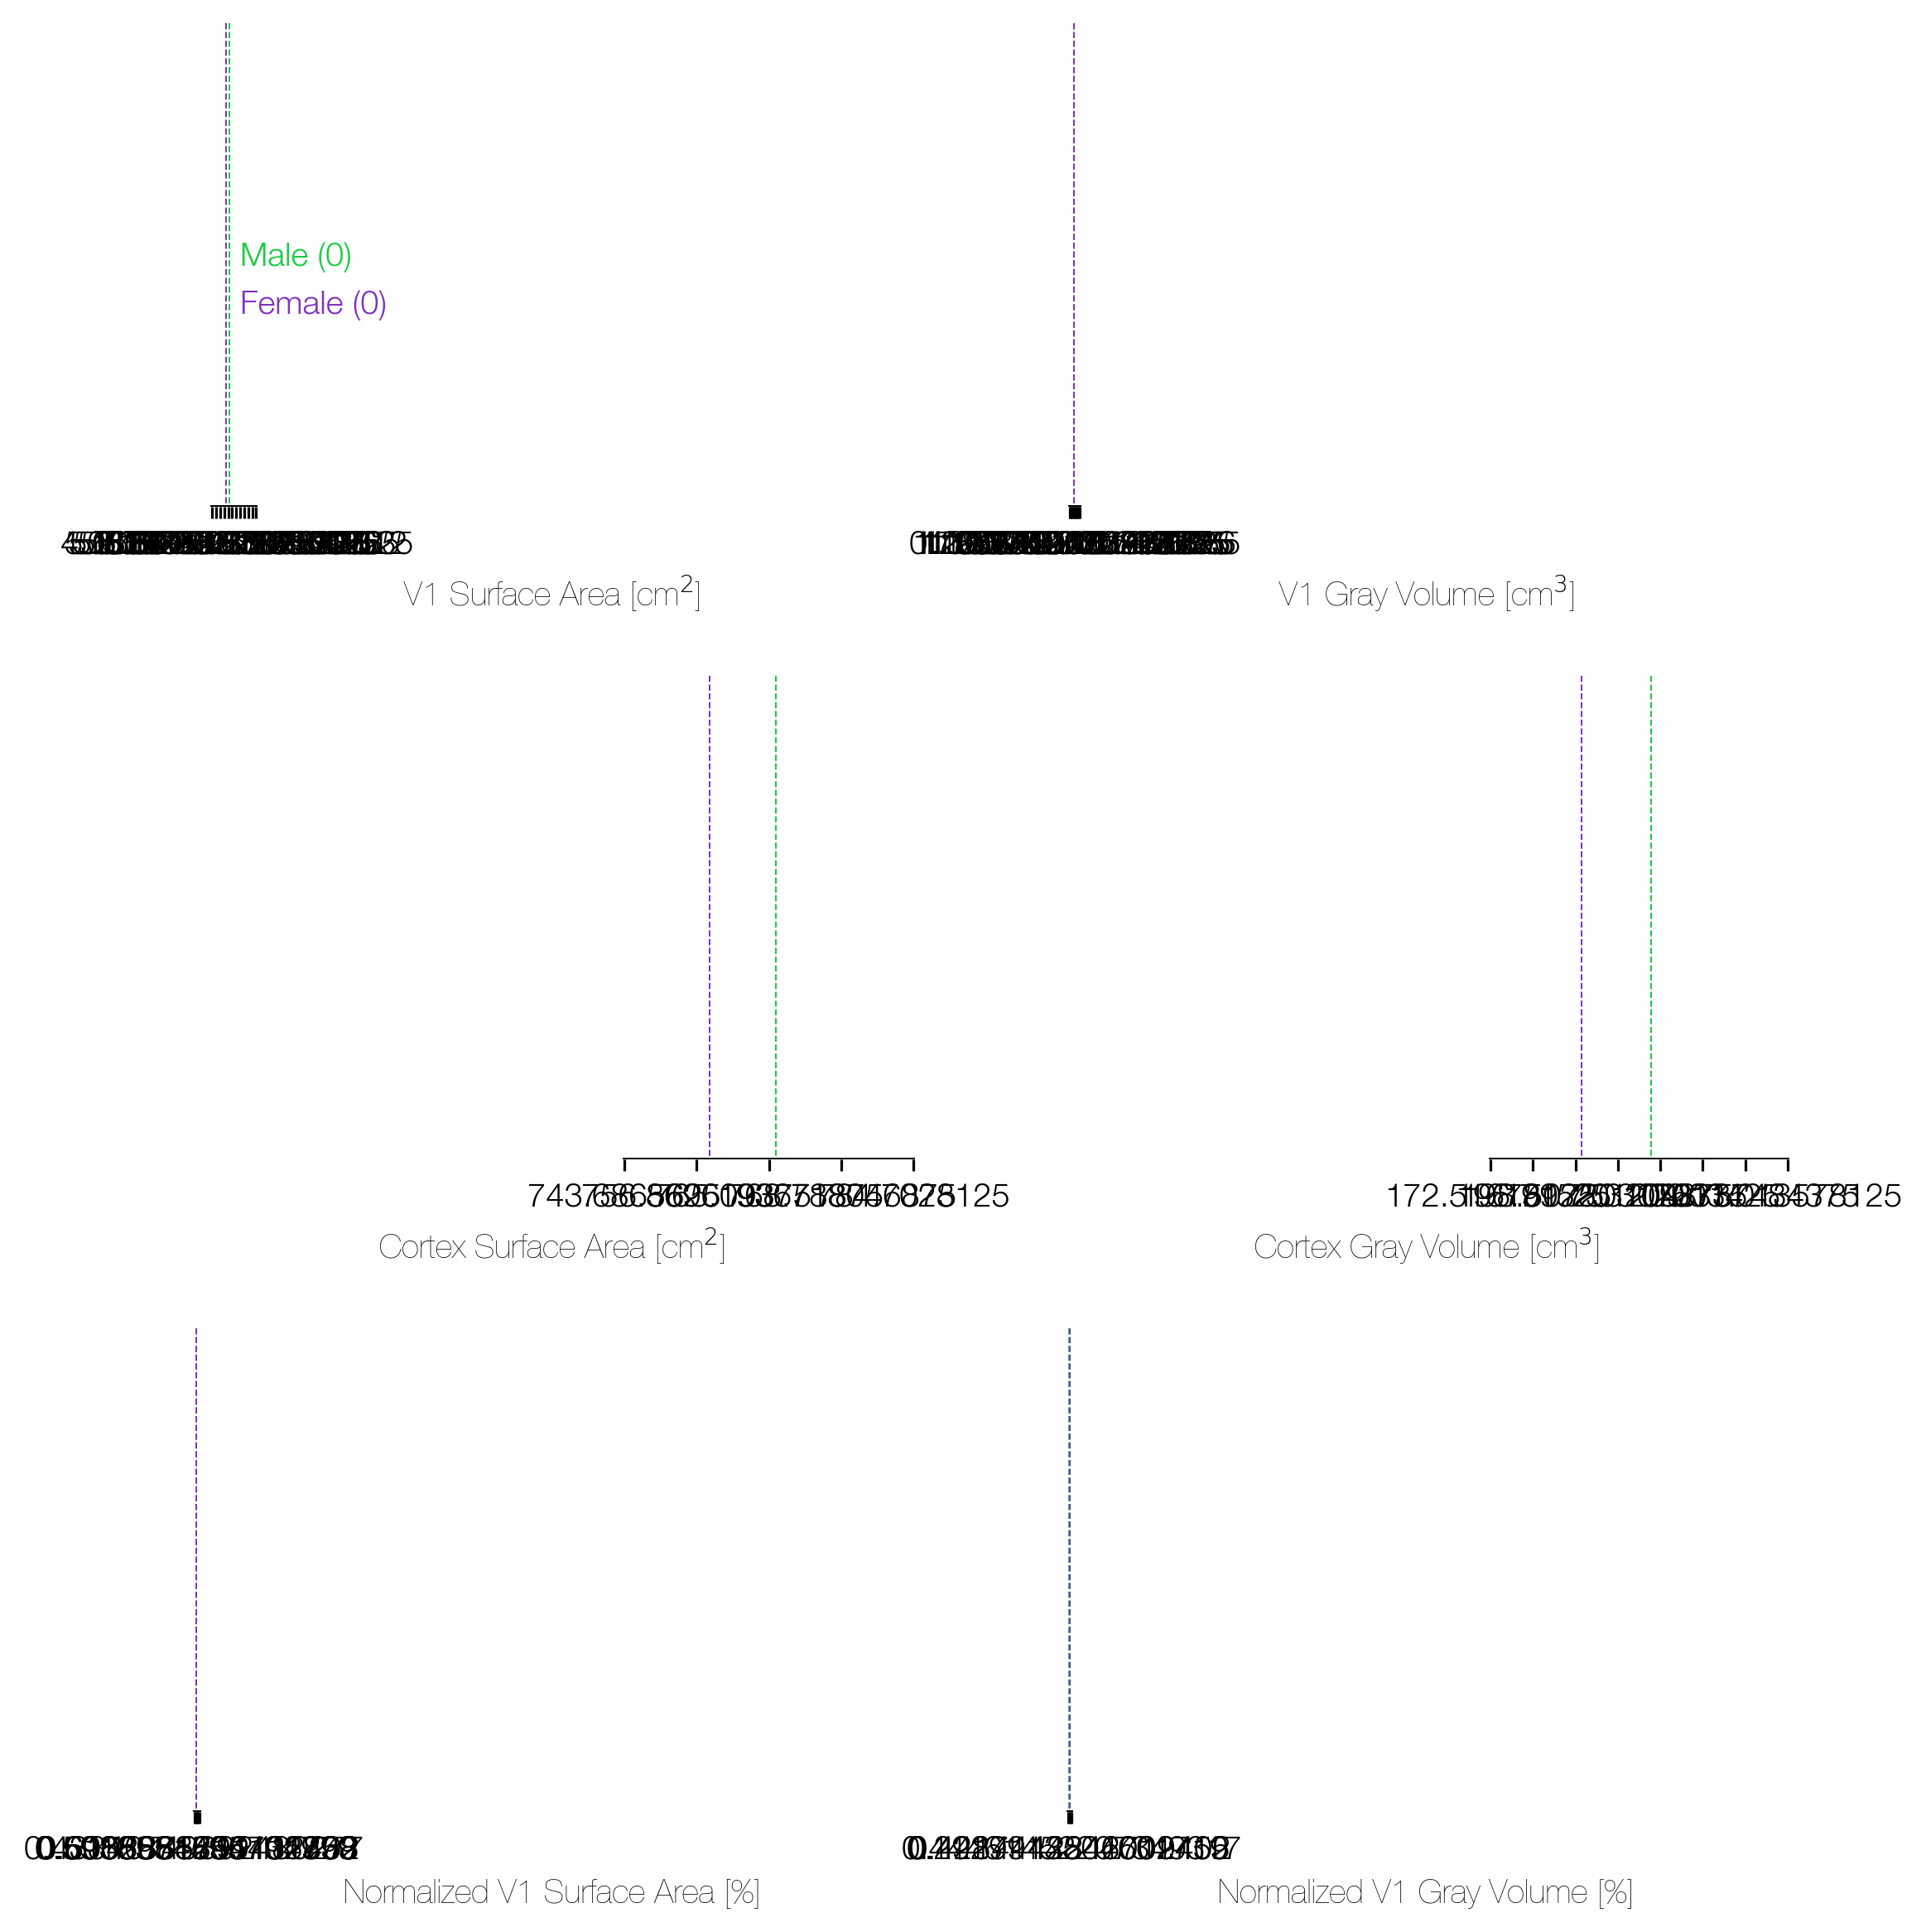

In [36]:
(f,axs) = plt.subplots(3,2, dpi=72*4, figsize=(7,7.5))

# We are plotting Gender here.
prop = 'Gender'

# Surface Area!
ax = axs[0,0]
sk = r'V1 Surface Area [cm$^2$]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(range(5,17))
ax.plot([5,16],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)
(nm,nf) = [len([1 for (ii,r) in dat.iterrows() if r[prop] == g])
           for g in ['M','F']]
ax.text(12, 0.5, 'Male (%d)' % nm,   color=colors['M'])
ax.text(12, 0.7, 'Female (%d)' % nf, color=colors['F'])

ax = axs[1,0]
sk = r'Cortex Surface Area [cm$^2$]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(range(750,1251,125))
ax.plot([750,1250],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)
(nm,nf) = [len([1 for (ii,r) in dat.iterrows() if r[prop] == g])
           for g in ['M','F']]

ax = axs[2,0]
sk = r'Normalized V1 Surface Area [%]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(np.arange(0.5,1.76,0.25))
ax.plot([0.5,1.75],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)
(nm,nf) = [len([1 for (ii,r) in dat.iterrows() if r[prop] == g])
           for g in ['M','F']]

# Volume!
ax = axs[0,1]
sk = r'V1 Gray Volume [cm$^3$]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(np.arange(0.75, 3.26, 0.25))
ax.plot([0.75, 3.25],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)

ax = axs[1,1]
sk = r'Cortex Gray Volume [cm$^3$]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(np.arange(200, 341, 20))
ax.plot([200, 340],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)
    
ax = axs[2,1]
sk = r'Normalized V1 Gray Volume [%]'
sns.violinplot(x=sk, y=prop, data=dat, palette=[colors['M'], colors['F']],
               split=True, ax=ax, cut=0, bw=0.2, inner=None, linewidth=0.5)
for (y,g) in zip([0,1], ['M','F']):
    xs = [r[sk] for (ii,r) in dat.iterrows() if r[prop] == g]
    ax.scatter(xs, [y]*len(xs), c=[(0,0,0,0.25)], s=2)
ax.set_ylabel(None)
ax.set_yticks([])
ax.set_xticks(np.arange(0.3,1.25,0.3))
ax.plot([0.3,1.2],[1.5,1.5], 'k-', lw=1)
ax.set_ylim(1.5,-0.5)
for s in ['top','right','left','bottom']: ax.spines[s].set_visible(False)
# Draw the two median lines
(m, f) = [np.median(ny.util.dataframe_select(dat, Gender=q)[sk].values)
          for q in ['M','F']]
for p in ax.plot([m,m], [-0.5,1.5], '--', lw=0.5, c=colors['M']): p.set_zorder(-1)
for p in ax.plot([f,f], [-0.5,1.5], '--', lw=0.5, c=colors['F']): p.set_zorder(-1)
    
plt.subplots_adjust(0,0,1,1,0.1,0.35)
plt.savefig(os.path.join(figures_path, 'MF-sizes.pdf'),
            bbox_inches='tight')

In [ ]:
####################################################################################################
def cmag_function(varea, ecc_roi, dataframe=Ellipsis, min_weight=0.04, nnearest=0.1,
                  surface_area_label='midgray_surface_area'):
    '''
    prf_size_function(v, ecc_roi) yields a function f(t) for angle t (in radians, starting
      at the positive x-axis and increasing the counter-clockwise direction) whose value
      r = f(t) consists of the median pRF size r in the given ecc_roi at the given polar
      angle t. The visual area v must be 1, 2, or 2 and specifies which visual area is
      represented by the returned function.
      
    The ecc_roi argument must be 0, 1, 2, 3, or 4, representing (0) 0-0.5 deg, (1) 0.5-1
    deg, (2) 1-2 deg, (3) 2-4 deg, or (4) 4-7 deg of eccentricity.
    
    Note that the function f(t) does not accept polar angle in degrees; rather it expects
    the polar angle in radians as is typically used in math (RHM, UVM, LHM, LVM
    correspond to 0, pi/2, +/- pi, -pi/2).

    The function f may also be called as f(t, pctls) in which case the value r that is 
    returned will be an NxM matrix where N is the number of elements in t and m is the
    number of elements in pctls. The typical call of f(t) is equivalent to f(t, 0.5).
    
    The following options may be given:
      * dataframe (Ellipsis) specifies that an explicit dataframe should be used; if the
        value is Ellipsis, then data.dataframe is used.
      * min_weight (0.04) specifies the minimum variance explained threshold.
      * nnearest (500) specifies the number of nearby vertices to include.
    '''
    from neuropythy.util import zdivide
    if not pimms.is_vector(ecc_roi): ecc_roi = [ecc_roi]
    ecc_roi = [int(er) for er in ecc_roi]
    for er in ecc_roi:
        if er < 0 or er > 4: raise ValueError('ecc roi must be 0, 1, 2, 3, or 4')
    varea = int(varea)
    if varea not in (1,2,3): raise ValueError('visual area must be 1, 2, or 3')
    df = data.dataframe if dataframe is Ellipsis else dataframe
    if min_weight is None or min_weight < 0: min_weight = 0
    # okay, what sectors do we need?
    scts = [s for s in data.sector_labels if s is not None
            if int(s[1]) == varea and int(s[3]) in ecc_roi]
    sctnos = np.array([data.sector_label_index[s] for s in scts])
    if len(sctnos) == 0: raise ValueError('no sectors selected')
    # collect some meta-data about our sectors:
    sctno2eccroi = np.array([int(s[-1]) if s else -1 for s in data.sector_labels])
    eccroi2minecc = np.array([0,0.5,1,2,4])
    eccroi2maxecc = np.array([0.5,1,2,4,7])
    # okay, now let's get all the data in these sectors
    d = df.loc[np.isin(df['visual_sector'], sctnos)]
    # the sum of surface area is the true total area; we will want to scale things later
    total_surface_area = np.sum(d[surface_area_label])
    # for any of those prfs that do not lie in the sector, or that don't meet the
    # variance explained cutoff, we want to eliminate them
    (lr,hno) = np.unique(d['hemi'], return_inverse=True)
    hno = 1 - 2*hno # lh-> 1, rh-> -1
    pa = np.mod(d['prf_polar_angle'] + 180, 360) - 180
    er = sctno2eccroi[d['visual_sector']]
    (mne,mxe) = (eccroi2minecc[er], eccroi2maxecc[er])
    ec = d['prf_eccentricity']
    va = d['prf_variance_explained']
    subii = (np.sign(pa) == hno) & (ec >= mne) & (ec <= mxe) & (va >= min_weight)
    # ok, subsample again
    d = d.loc[subii]
    (hno,pa,ec) = [u[subii] for u in (hno,pa,ec)]
    # surface area scaling factor:
    sa = d[surface_area_label]
    used_surface_area = np.sum(sa)
    if np.isclose(used_surface_area, 0): raise ValueError('No data found')
    sa_scale = total_surface_area / used_surface_area
    # okay, now we can use these to make two separate (lh and rh) nearness functions
    try:    from scipy.spatial import cKDTree as kdtree
    except: from scipy.spatial import KDTree  as kdtree
    hiis = {h:(hno == k) for (h,k) in zip(['lh','rh'], [1,-1])}
    if np.sum(hiis['lh']) < 100: raise ValueError('No data in LH')
    if np.sum(hiis['rh']) < 100: raise ValueError('No data in RH')
    pa   = {h:pa[ii].values for (h,ii) in six.iteritems(hiis)}
    ec   = {h:ec[ii].values for (h,ii) in six.iteritems(hiis)}
    sa   = {h:sa[ii].values for (h,ii) in six.iteritems(hiis)}
    # make the nearest functions:
    nears = {h:kdtree(np.reshape(pa[h], (-1,1))) for h in ['lh','rh']}
    # okay, now we can write the function itself:
    def ff(t):
        if pimms.is_scalar(t): return ff([t])[0]
        # find near-vals for t; we need to convert into VF degrees:
        t = np.mod(90 - np.asarray(t)*180.0/np.pi + 180, 360) - 180
        hii = np.sign(t)
        hii[hii == 0] = 1
        cmag = np.full(len(t), np.nan)
        for (h,ii) in zip(['lh','rh'], [hii == 1, hii == -1]):
            if np.sum(ii) == 0: continue
            th = t[ii]
            near = nears[h]
            nn = int(nnearest if nnearest >= 1 else nnearest * near.n)
            nn = np.max([nn,100])
            nn = np.min([nn,int((near.n + 1)/2)])
            if nn < 2:
                warnings.warn('Skipping %s with %d points...' % (h, near.n))
                continue
            wh = near.query(np.reshape(th, (-1,1)), nn)[1] #wh is len(th) x nn
            angle = np.reshape(pa[h][wh.flat], wh.shape)
            sarea = np.reshape(sa[h][wh.flat], wh.shape)
            eccen = np.reshape(ec[h][wh.flat], wh.shape)
            (tmn,tmx) = [mnmx(angle, 1) * np.pi/180.0 for mnmx in (np.min,np.max)]
            (rmn,rmx) = (np.min(eccen, 1), np.max(eccen, axis=1))
            visarea = (tmx - tmn) * 0.5 * (rmx**2 - rmn**2)
            cmag[ii] = zdivide(sa_scale*np.sum(sarea, 1), visarea)
        return cmag
    return ff

In [ ]:
def safe(f, *args, **kw):
    try:    return f(*args, **kw)
    except: return None
def mean_cmag(fs):
    fs = [f for f in fs if f is not None]
    def meanfn(t, pctls=[2.5,25,47.5,50,52.5,75,97.5]):
        if pimms.is_scalar(t): return meanfn([t],pctls)[0]
        cms = np.array([f(t) for f in fs]).T
        if pctls is None: return np.transpose([np.mean(cms,1), np.std(cms,1)/np.sqrt(len(fs))])
        else: return np.percentile(cms, pctls, axis=1)
    return meanfn
subject_cmags = {sid: {va: [safe(cmag_function, va, k, min_weight=0, dataframe=df)
                            for k in [(0,1),(2,3),4]]
                       for va in (1,2,3)}
                 for sid in data.subject_list
                 for df in [data.dataframe.loc[data.dataframe['subject'] == sid]]}
all_cmags = {va: [mean_cmag([subject_cmags[sid][va][k] for sid in data.subject_list])
                  for k in range(3)]
             for va in (1,2,3)}

In [ ]:
(fig,axs) = plt.subplots(1,3, figsize=(7.5,7.5/3))
colors = np.array([(0,0,1),(0,1,1),(0,1,0),(1,1,0),(1,0,0)])
colors = colors / np.reshape(np.sqrt(np.sum(colors**2, axis=1)), (-1,1))
thetas = np.arange(-np.pi/2, 3*np.pi/2, 0.02)
def xy_to_plot(xy):
    (x,y) = np.transpose(xy) if len(xy) != 2 else np.asarray(xy)
    r0 = np.sqrt(x**2 + y**2)
    r  = np.log(r0)
    sc = ny.util.zdivide(r, r0)
    #sc = 1
    return np.transpose([x*sc, y*sc])
def tr_to_plot(tr):
    (t,r) = np.transpose(tr) if len(tr) != 2 else np.asarray(tr)
    (x,y) = (r*np.cos(t), r*np.sin(t))
    return xy_to_plot(np.transpose([x,y]))
def pgon(yl,yu):
    tr = np.transpose([np.concatenate([thetas, np.flip(thetas)]),
                       np.concatenate([yu, np.flip(yl)])])
    return tr_to_plot(tr)
alph = lambda c,a: (c[0],c[1],c[2],a)
for (area,ax) in zip([1,2,3], axs):
    (xd,yd) = xy_to_plot([[0,0],[-512,512]]).T
    ax.plot(xd,yd, 'k-', lw=0.5)
    ax.plot(yd,xd, 'k-', lw=0.5)
    (x,y) = xy_to_plot([[2,8,32,128,512],[0,0,0,0,0]]).T
    for x in x: ax.add_patch(plt.Circle([0,0], x, fill=False, edgecolor=(0.5,0.5,0.5), lw=0.25))
    for s in six.itervalues(ax.spines): s.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    #for (sct,clr) in enumerate(colors):
    for (k,clr) in enumerate([(0,0,1), (0,1,0), (1,0,0)]):
        f = all_cmags[area][k]
        z = f(thetas, [25,50,75])
        ax.add_patch(plt.Polygon(pgon(z[0], z[2]), facecolor=alph(clr,0.2), edgecolor=None))
        (x,y) = tr_to_plot([thetas, z[1]]).T
        ax.plot(x, y, c=clr)
    lm = xy_to_plot([[-524,524],[0,0]]).T[0]
    ax.set_xlim(lm)
    ax.set_ylim(lm)
plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
(fig,axs) = plt.subplots(1,3, figsize=(7.5,7.5/3))
colors = np.array([(0,0,1),(0,1,1),(0,1,0),(1,1,0),(1,0,0)])
colors = colors / np.reshape(np.sqrt(np.sum(colors**2, axis=1)), (-1,1))
thetas = np.arange(-np.pi/2, 3*np.pi/2, 0.02)
def xy_to_plot(xy):
    (x,y) = np.transpose(xy) if len(xy) != 2 else np.asarray(xy)
    #r0 = np.sqrt(x**2 + y**2)
    #r  = np.log(r0)
    #sc = ny.util.zdivide(r, r0)
    sc = 1
    return np.transpose([x*sc, y*sc])
def tr_to_plot(tr):
    (t,r) = np.transpose(tr) if len(tr) != 2 else np.asarray(tr)
    (x,y) = (r*np.cos(t), r*np.sin(t))
    return xy_to_plot(np.transpose([x,y]))
def pgon(yl,yu):
    tr = np.transpose([np.concatenate([thetas, np.flip(thetas)]),
                       np.concatenate([yu, np.flip(yl)])])
    return tr_to_plot(tr)
alph = lambda c,a: (c[0],c[1],c[2],a)
for (area,ax) in zip([1,2,3], axs):
    (xd,yd) = xy_to_plot([[0,0],[-512,512]]).T
    ax.plot(xd,yd, 'k-', lw=0.5)
    ax.plot(yd,xd, 'k-', lw=0.5)
    (x,y) = xy_to_plot([[1,2,3,4],[0,0,0,0]]).T
    for x in x: ax.add_patch(plt.Circle([0,0], x, fill=False, edgecolor=(0.5,0.5,0.5), lw=0.25))
    for s in six.itervalues(ax.spines): s.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    #for (sct,clr) in enumerate(colors):
    for (k,clr) in enumerate([(0,0,1), (0,1,0), (1,0,0)]):
        f = lambda th,pp: np.sqrt(all_cmags[area][k](th,pp))*all_prfszs[area][k](th,pp)
        z = f(thetas, [25,50,75])
        #ax.add_patch(plt.Polygon(pgon(z[0], z[2]), facecolor=alph(clr,0.2), edgecolor=None))
        (x,y) = tr_to_plot([thetas, z[1]]).T
        ax.plot(x, y, c=clr)
    lm = xy_to_plot([[-4,4],[0,0]]).T[0]
    ax.set_xlim(lm)
    ax.set_ylim(lm)
plt.subplots_adjust(wspace=0, hspace=0);

### Correlation of HMA/VMA with Surface Area

It would be interesting to know if the extent of asymmetry in subjects correlated with the size of their V1. We perform and plot these data here.

In [39]:
def hemi_asymmetry(sid, h):
    '''
    hemi_asymmetry(sid, h) yields the (VMA, HVA) for the given subject ID
      and hemisphere using a minimum eccentricity of 1° and a max of 6°.
    '''
    dfselect = ny.util.dataframe_select
    subrois = dfselect(data.DROI_table, sid=sid, hemisphere=h, angle_delta_deg=10)
    subrois = subrois.loc[subrois['min_eccentricity_deg'] >= 1]
    subrois = subrois.loc[subrois['max_eccentricity_deg'] <= 6]

    (sa_upp, sa_low, sa_vrt, sa_hrz) = [
        np.sum(dfselect(subrois, boundary=b)['surface_area_mm2'].values)
        for b in ['ventral','dorsal','vertical','horizontal']]
    (sa_upp, sa_low, sa_vrt, sa_hrz)
    hva = (sa_hrz - sa_vrt) / np.mean([sa_hrz,sa_vrt]) * 100
    vma = (sa_low - sa_upp) / np.mean([sa_upp,sa_low]) * 100
    return (vma, hva)
def subject_hemidata(sid):
    '''
    subject_hemidata(sid) yields a list of dicts of relevant hemisphere-based
      data for the given subject id.
    '''
    tbl = []
    for h in ['lh','rh']:
        hem = data.subjects[sid].hemis[h]
        (vma,hva) = hemi_asymmetry(sid, h)
        sa = hem.prop('midgray_surface_area')
        cx = hem.prop('cortex_label')
        ec = hem.prop('inf_eccentricity')
        ec = (ec >= 1) & (ec <= 6)
        v1 = (hem.prop('inf_visual_area') == 1) & ec
        v2 = (hem.prop('inf_visual_area') == 2) & ec
        row = {'sid': sid, 'hemisphere': h,
               'cortex_surface_area_mm2': np.sum(sa[cx]),
               'v1_surface_area_mm2': np.sum(sa[v1]),
               'v2_surface_area_mm2': np.sum(sa[v2]),
               'HVA': hva, 'VMA': vma}
        tbl.append(row)
    return tbl

In [ ]:
use_mp = True

#with warnings.catch_warnings(record=True) as w:
#warnings.simplefilter('ignore', ResourceWarning)
hemi_table = ny.auto_dict(None, [])
nsubs = len(data.subject_list)
if use_mp:
    import multiprocessing as mp
    nprocs = mp.cpu_count()
    for ii in np.arange(0, nsubs, nprocs):
        mx = np.min([nsubs, ii + nprocs])
        print(" %2d - %3d%%" % ((ii + 1)/nsubs * 100, mx/nsubs * 100))
        with mp.Pool(nprocs) as pool:
            tbls = pool.map(subject_hemidata, data.subject_list[ii:ii+nprocs])
        # add these data into the overall roi table
        for tbl in tbls:
            for row in tbl:
                for (k,v) in six.iteritems(row):
                    hemi_table[k].append(v)
else:
    for (ii,sid) in enumerate(subject_list):
        if ii % 10 == 9:
            print('%3d (%d), %4.1f%%' % (ii, sid, ii/len(subject_list)*100.0))
            # Prevent accumulation of cache data by reloading neuropythy and
            # forgetting the loaded subjects every so often.
            ny = ny.reload_neuropythy()
            forget_subjects()
        tbl = subject_hemidata(sid)
        for row in tbl:
            for (k,v) in six.iteritems(row):
                hemi_table[k].append(v)
# Done; now just turn it into a dataframe:
hemi_table = ny.to_dataframe(hemi_table)
# we want the roi_table to be indexed on subject and hemisphere
hemi_table.set_index(['sid', 'hemisphere']);

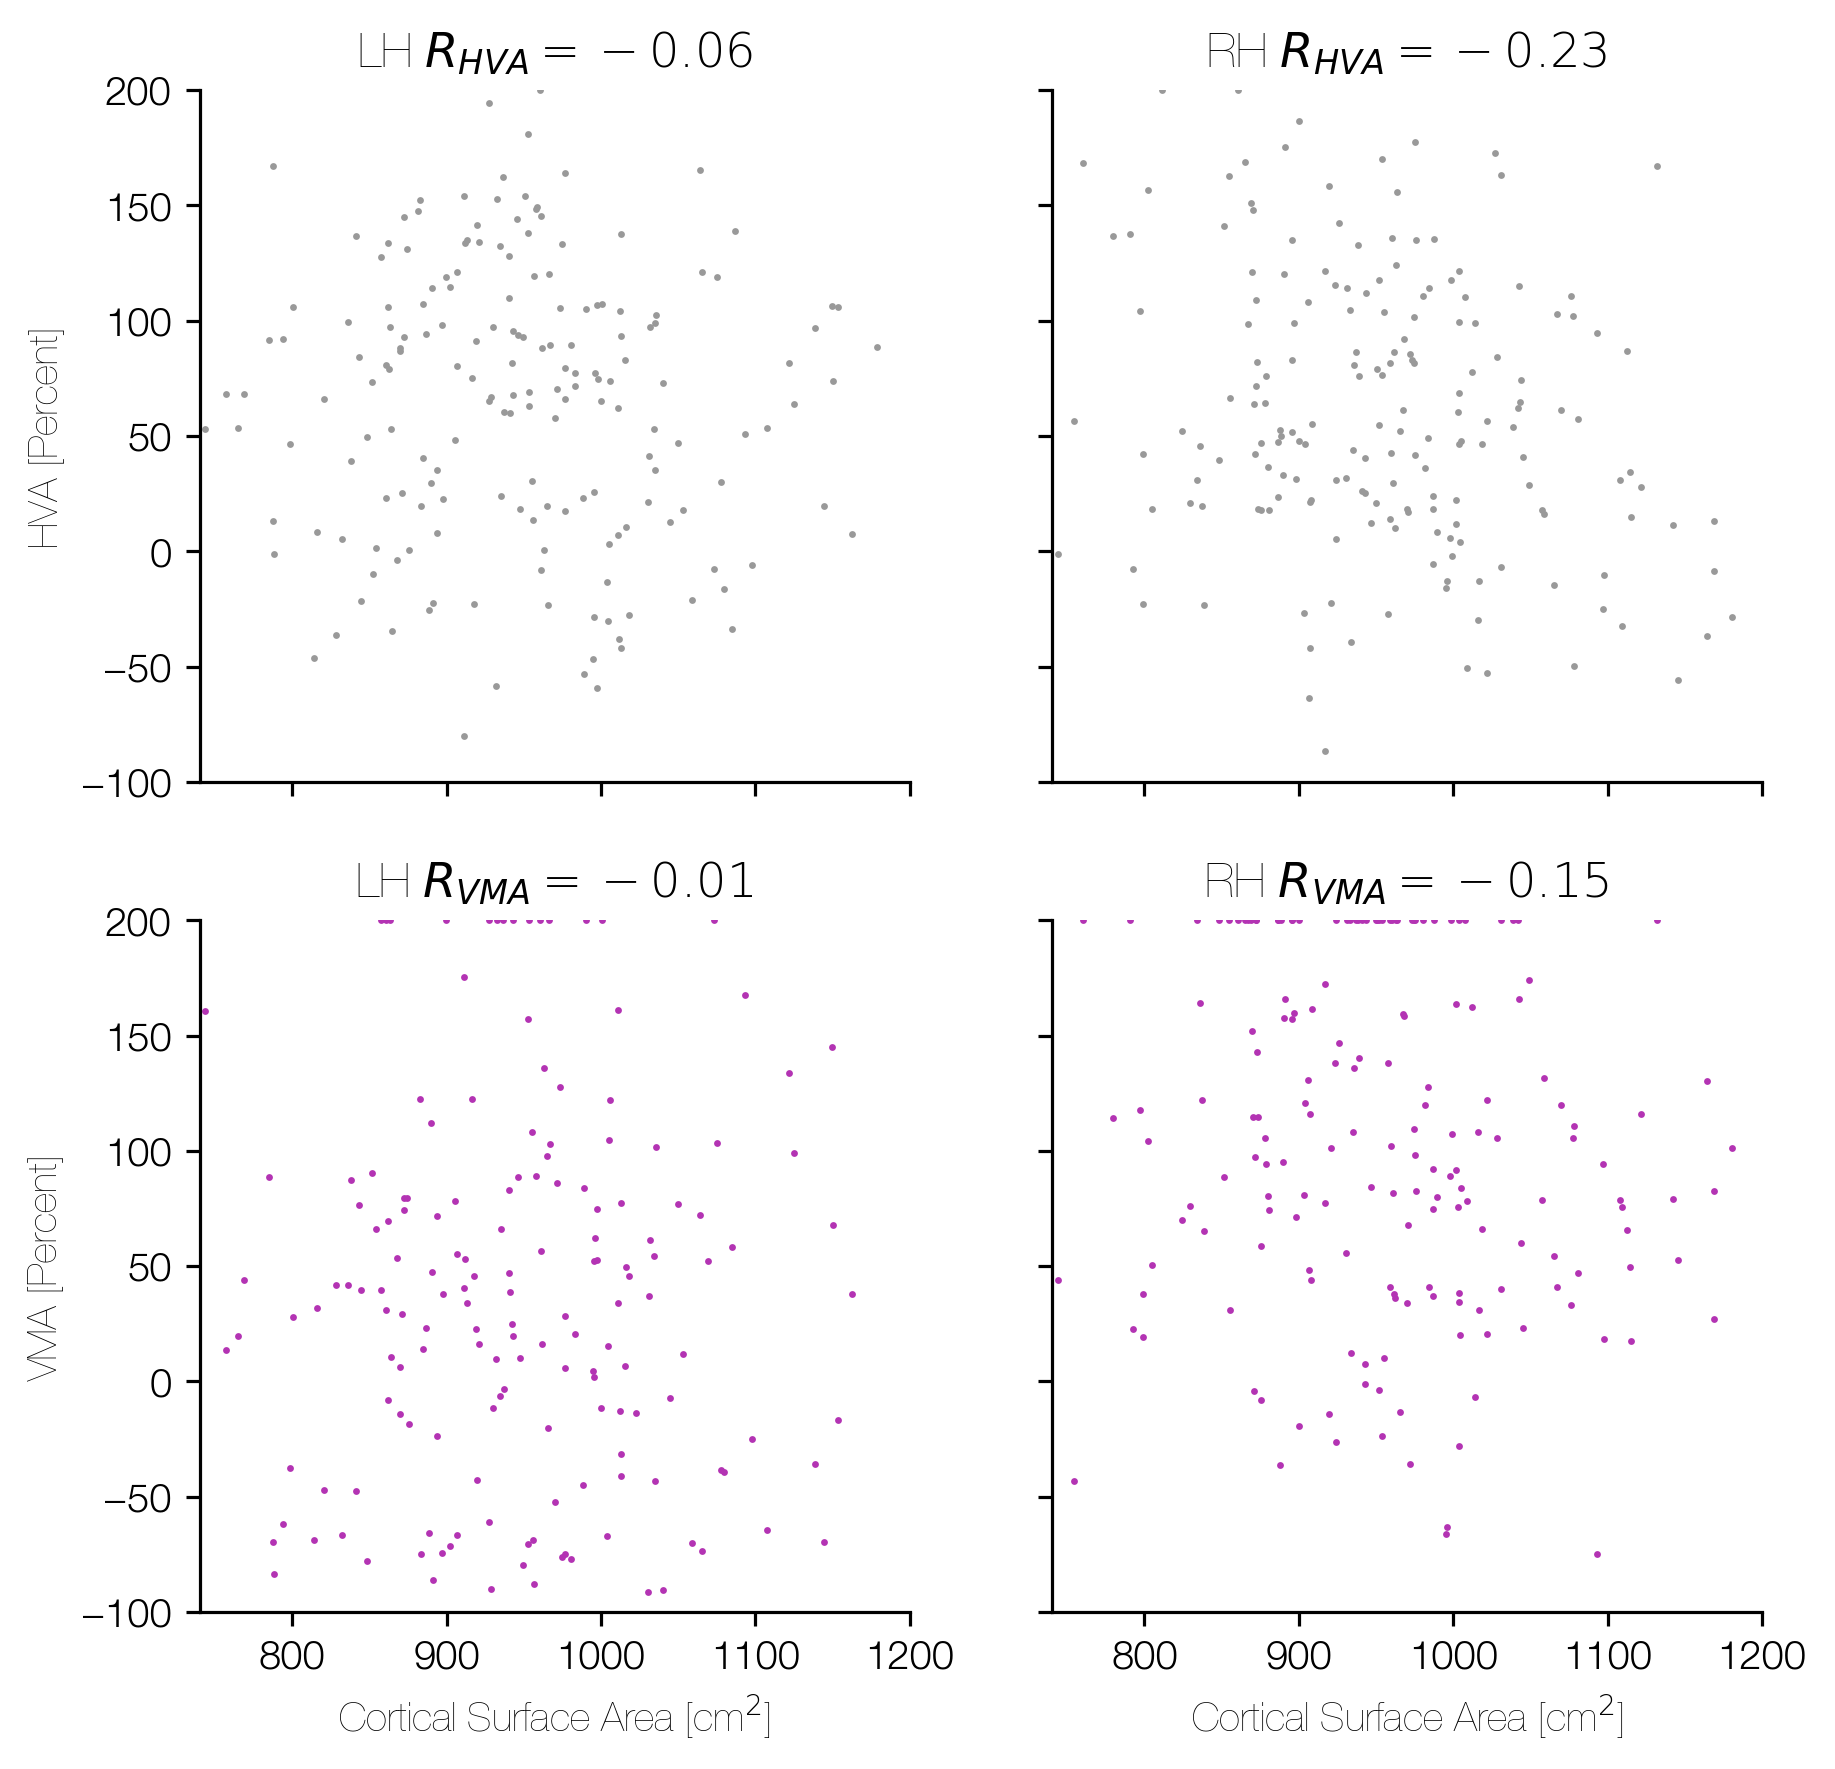

In [48]:
(fig,axs) = plt.subplots(2,2, figsize=(7,7), dpi=72*4, sharex=True, sharey=True)
#fig.subplots_adjust(0,0,1,1,0,0)

for (h,axcol) in zip(['lh','rh'], axs.T):
    if h == 'lr': df = hemi_table
    else: df = ny.util.dataframe_select(hemi_table, hemisphere=h)
    sacx = df['cortex_surface_area_mm2'].values / 10.0**2
    (xmn,xmx) = (740,1200)
    #sacx = df['v2_surface_area_mm2'].values / 10.0**2
    #(xmn,xmx) = (4, 12)
    for (q,ax) in zip(['HVA','VMA'], axcol):
        u = df[q].values
        clr = colors['vertical' if q == 'VMA' else 'horizontal']
        ii = np.isfinite(u)
        ax.scatter(sacx[ii], u[ii], s=0.5, c=[clr])
        ax.set_ylim([-100,200])
        ax.set_xlim([xmn, xmx])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        cval = np.corrcoef(sacx[ii], u[ii])[0,1]
        rtxt = r'%s $R_{%s} = %4.2f$' % (h.upper(), q, cval)
        #ax.text(670, 150, rtxt)
        ax.set_title(rtxt)
axs[0,0].set_ylabel('HVA [Percent]')
axs[1,0].set_ylabel('VMA [Percent]')
axs[1,0].set_xlabel(r'Cortical Surface Area [cm$^2$]')
axs[1,1].set_xlabel(r'Cortical Surface Area [cm$^2$]')

pass